# Keras convolution neural network barcode recognition

In [1]:
import os
import gc
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display
from log_progress import log_progress

from skimage import filters

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, UpSampling2D

from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

### Объявляем пути к файлам

##### Набор данных можно скачать по ссылке http://artelab.dista.uninsubria.it/downloads/datasets/barcode/hough_barcode_1d/1d_barcode_extended_plain.zip

In [2]:
dataset_folder = 'dataset'
dataset_original_images = dataset_folder + '/original'
dataset_detection_images = dataset_folder + '/detection'
dataset_numpy_file = 'dataset.npy'

### Получаем файлы 

In [3]:
original_images_filenames = os.listdir(dataset_original_images)
print('Всего файлов в датасете {}'.format(len(original_images_filenames)))

Всего файлов в датасете 365


### Проводим подготовку данных

In [4]:
subsample_region_size = 256

dataset = []

for filename in log_progress(original_images_filenames):
    original_filename = os.path.join(dataset_original_images, filename)
    detection_filename = os.path.join(dataset_detection_images, filename)
    
    original_image = Image.open(original_filename)
    detection_image = Image.open(detection_filename)

    minimum_side = subsample_region_size
    
    original_image_resized = original_image.resize((minimum_side, minimum_side), Image.ANTIALIAS).convert('L')
    detection_image_resized = detection_image.resize((minimum_side, minimum_side), Image.ANTIALIAS).convert('L')
    
    dataset.append((np.array(original_image_resized).astype('float32'),
                    np.array(detection_image_resized).astype('float32')))

                      
print('Преобразовываем в массив NumPy')
                
dataset = np.array(dataset)

print('Перемешиваем')

np.random.shuffle(dataset)

print('Сохраняем')

np.save(os.path.join(dataset_folder, dataset_numpy_file), dataset)

print('Набор данных {} содержит {} элемет(ов)'.format(dataset_numpy_file, len(dataset)))

Преобразовываем в массив NumPy
Перемешиваем
Сохраняем
Набор данных dataset.npy содержит 365 элемет(ов)


### Загружаем набор данных и подготавливаем их к процессу обучения
- Загружаем файл NumPy
- Разделяем на обучающую и тестовую выборки

In [5]:
train_ratio = 0.8

dataset = np.load(os.path.join(dataset_folder, dataset_numpy_file))

test, train = dataset[:int(len(dataset) * train_ratio)], dataset[int(len(dataset) * train_ratio):]

train_x, train_y, test_x, test_y = test[:, 0], test[:, 1], train[:, 0], train[:, 1]

print('Набор данных загружен. \
Элементов в обучающей выборке {}, элементов в тестовой выборке {}'.format(len(test), len(train)))

Набор данных загружен. Элементов в обучающей выборке 292, элементов в тестовой выборке 73


### Преобразуем данные к 4D формату и нормализуем их

In [6]:
train_x = np.array([d.reshape((subsample_region_size, subsample_region_size, 1)) for d in train_x])
train_y = np.array([d.reshape((subsample_region_size, subsample_region_size, 1)) for d in train_y])
test_x = np.array([d.reshape((subsample_region_size, subsample_region_size, 1)) for d in test_x])
test_y = np.array([d.reshape((subsample_region_size, subsample_region_size, 1)) for d in test_y])

train_x = train_x / 255.0
train_y = train_y / 255.0
test_x = test_x / 255.0
test_y = test_y / 255.0

print('Данные нормализованы')

Данные нормализованы


### Отображаем элементы обучающей выборки

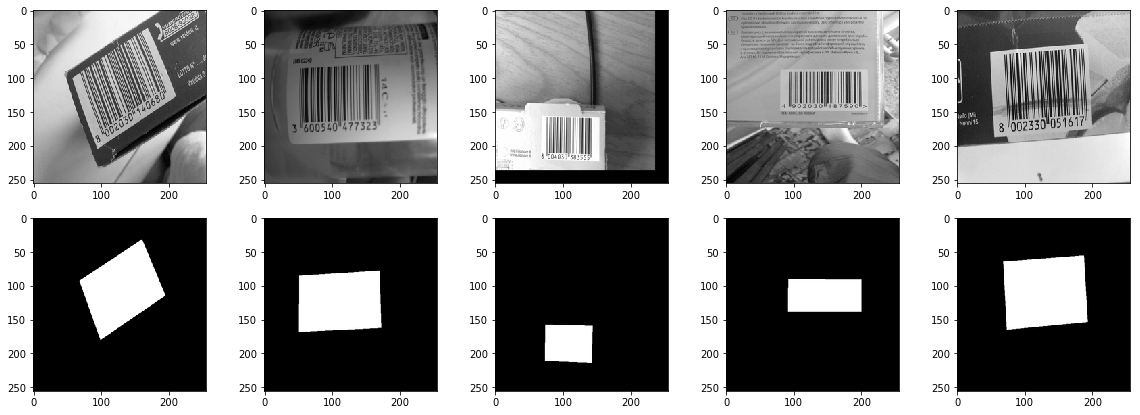

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
for i in range(5):
    rnd = np.random.randint(0, len(train_x))
    ax[0, i].imshow(train_x[rnd].reshape((subsample_region_size, subsample_region_size)), cmap='gray')
    ax[1, i].imshow(train_y[rnd].reshape((subsample_region_size, subsample_region_size)), cmap='gray')

### Строим модель сверточной нейронной сети

In [8]:
model = Sequential()

model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='relu', 
                        input_shape=(subsample_region_size, subsample_region_size, 1),
                        padding='same'
                        ))

model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='sigmoid',
                        padding='same'
                        ))

model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Dense(64, activation='relu'))

model.add(Convolution2D(filters=1, 
                        kernel_size=(3, 3),
                        activation='sigmoid',
                        padding='same'
                        ))

model.add(UpSampling2D(size=(2,2)))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy','mse'])

display(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dense_1 (Dense)              (None, 128, 128, 64)      4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 1)       577       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 256, 256, 1)       0         
Total params: 23,553
Trainable params: 23,553
Non-trainable params: 0
_________________________________________________________________


None

### Обучаем нейронную сеть

In [9]:
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=10, batch_size=10);

Train on 292 samples, validate on 73 samples
Epoch 1/10
292/292 [==============================] - 339s - loss: 0.3990 - acc: 0.8414 - mean_squared_error: 0.1175 - val_loss: 0.3854 - val_acc: 0.8602 - val_mean_squared_error: 0.1122
Epoch 2/10
292/292 [==============================] - 338s - loss: 0.3677 - acc: 0.8671 - mean_squared_error: 0.1061 - val_loss: 0.3681 - val_acc: 0.8602 - val_mean_squared_error: 0.1086
Epoch 3/10
292/292 [==============================] - 339s - loss: 0.3445 - acc: 0.8671 - mean_squared_error: 0.1004 - val_loss: 0.3271 - val_acc: 0.8602 - val_mean_squared_error: 0.0974
Epoch 4/10
292/292 [==============================] - 341s - loss: 0.3031 - acc: 0.8686 - mean_squared_error: 0.0884 - val_loss: 0.3201 - val_acc: 0.9133 - val_mean_squared_error: 0.0840
Epoch 5/10
292/292 [==============================] - 352s - loss: 0.2532 - acc: 0.8889 - mean_squared_error: 0.0714 - val_loss: 0.2091 - val_acc: 0.9067 - val_mean_squared_error: 0.0563
Epoch 6/10
292/292 [

### Тестируем работу сети

In [10]:
model.save('network')

scores = model.evaluate(test_x, test_y, verbose=0)
print("Accuracy: {:.2f}%".format(scores[1] * 100))

Accuracy: 92.13%


### Проверим работу на тестовой выборке

In [11]:
model = models.load_model('network')

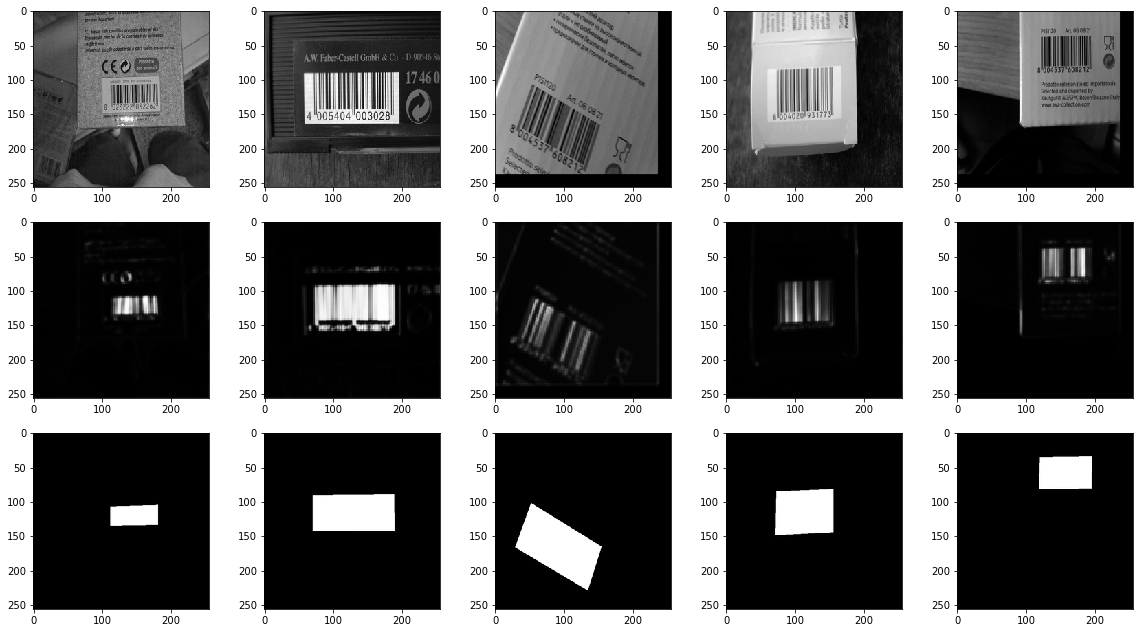

In [12]:
results = model.predict(test_x[:5])

fig, ax = plt.subplots(3, 5, figsize=(20, 11))
for i in range(5):
    ax[0, i].imshow(test_x[i].reshape((subsample_region_size, subsample_region_size)), cmap='gray')
    ax[2, i].imshow(test_y[i].reshape((subsample_region_size, subsample_region_size)), cmap='gray')
    ax[1, i].imshow(results[i].reshape((subsample_region_size, subsample_region_size)), cmap='gray')

### Проверим работу сети на изображении высокого разрешения

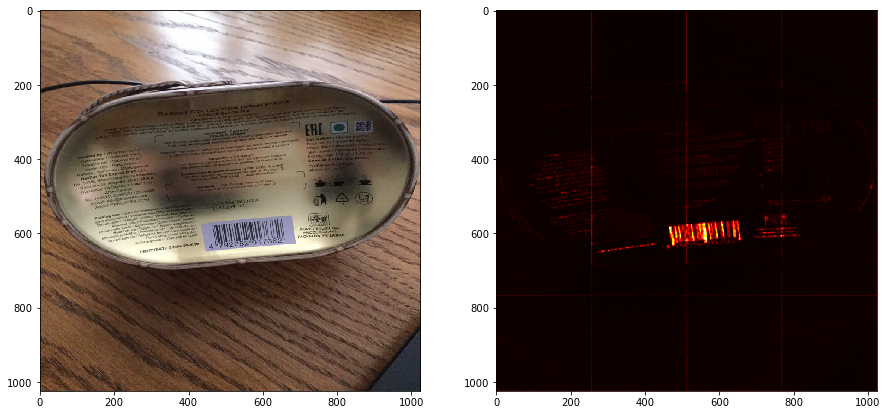

In [13]:
window_size = 256

max_side = int(512 * 2)

hires_image = Image.open('3.jpg').convert('RGB')
hires_image = hires_image.resize((max_side, max_side))

heat_map = np.zeros((max_side, max_side))

for x in range(window_size // 2, max_side - window_size // 2 + 1, window_size):
    for y in range(window_size // 2, max_side - window_size // 2 + 1, window_size):        
        
        hires_image_crop = hires_image.crop((x - window_size // 2,
                                             y - window_size // 2,
                                             x + window_size // 2,
                                             y + window_size // 2)).convert('L')
        
        hires_image_crop = np.array(hires_image_crop) / 255
        
        hires_image_crop = hires_image_crop.reshape((window_size, window_size, 1))
        
        result = model.predict(np.array([hires_image_crop]))
        
        result = np.squeeze(result)
        
        heat_map[y - window_size // 2:y + window_size // 2,
                 x - window_size // 2:x + window_size // 2] += result.reshape((window_size, window_size))
        
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(hires_image)
ax[1].imshow(heat_map, cmap='hot')
plt.show()